# Types of Data Augmentation

Data Augmentation is a regularisation technique that's used to avoid overfitting when training Computer Vision models. Adjustments are made to the original images in the training dataset before being used in training. Some example adjustments include; translating, croping, scaling, rotating, changing brightness and contrast. We do this to reduce the dependence of the model on spurious characteristics; e.g. training data may only contain faces that fill 1/4 of the image, so the model trainied without data augmentation might unhelpfully learn that faces can only be of this size.

After defining some utility functions to visualise the example images, this tutorial details each different augmentation that can be used to adjust both the position and the colors of images. We discuss augmentations that are combined into single functions, and conclude with a FAQ section.

In [1]:
%matplotlib inline
import mxnet as mx
import numpy as np
from matplotlib.pyplot import imshow

In [38]:
# utility functions for use in the tutorial

def plot_mx_array(array, clip=False):
    """
    Array expected to be 3 (channels) x heigh x width, and values are floats between 0 and 255.
    """
    assert array.shape[2] == 3, "RGB Channel should be last"
    if clip:
        array = array.clip(0,255)
    else:
        assert array.min().asscalar() >= 0, "Value in array is less than 0: found " + str(array.min().asscalar())
        assert array.max().asscalar() <= 255, "Value in array is greater than 255: found " + str(array.max().asscalar())
    array = array/255
    np_array = array.asnumpy()
    imshow(np_array)
    
    
def hwc_to_chw(array):
    """
    Changes the order of dimensions from (height * width * channel) to (channel * height * width)
    """
    return array.swapaxes(0,2).swapaxes(1,2)


def chw_to_hwc(array):
    """
    Changes the order of dimensions from (channel * height * width) to (height * width * channel)
    """
    return array.swapaxes(1,2).swapaxes(0,2)

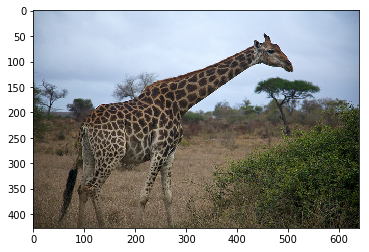

In [98]:
with open("./data/images/0_image.jpg", 'rb') as open_file:
        encoded_image = open_file.read()

example_image = mx.image.imdecode(encoded_image)

# image is loaded with `numpy.int8` datatype
# some functions such as `swapaxes` don't work on `int` types
# will convert to `float32`
example_image = example_image.astype("float32")
    
plot_mx_array(example_image)

# Position Augmentation

One form of augmentation effects the position of pixel values. Using combinations of slicing, scaling, translating, rotating and fliping the values of the original image can be shifted to create new images. Some operations (like scaling and rotation) require interpolation as pixels in the new image are combinations of pixels in the original image.

### Crop

You can use `mx.image.RandomCropAug` and `image.CenterCropAug` to create instances of the Augmenter class, which can be called just like a function. It's worth noting that the randomisation for `RandomCropAug` happens when calling the Augmenter, and not at the point of instantiation. You'll end up with different images each time you call the Augmenter, so it can't be used to apply the same augmentation to another image. `CenterCropAug` is determanistic and just takes the most central crop of given size.

example_image shape: (427, 640, 3)
aug_image shape: (100, 100, 3)


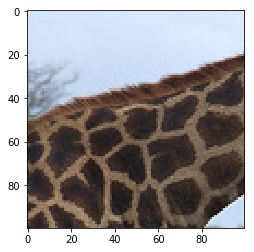

In [99]:
aug = mx.image.RandomCropAug(size=(100, 100))
aug_image = aug(example_image)
plot_mx_array(aug_image, clip=True)

print("example_image shape: " + str(example_image.shape))
print("aug_image shape: " + str(aug_image.shape))

### Resize

Use `mx.image.ResizeAug` and `mx.image.ForceResizeAug` for scaling the image.

`image.ResizeAug` scales the shortest edge to the defined size, and automatically adjusts the longest edge to maintain the aspect ratio of the input image.
`mx.image.ForceResizeAug` scales both height and width to the defined size, even if this doesn't preserve the aspect ratio.

example_image shape: (427, 640, 3)
aug_image shape: (50, 74, 3)


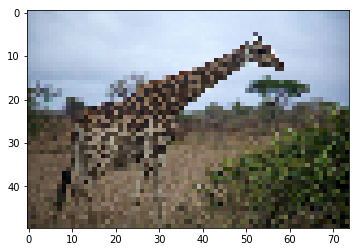

In [100]:
aug = mx.image.ResizeAug(size=50)
aug_image = aug(example_image)
plot_mx_array(aug_image, clip=True)

print("example_image shape: " + str(example_image.shape))
print("aug_image shape: " + str(aug_image.shape))

example_image shape: (427, 640, 3)
aug_image shape: (50, 100, 3)


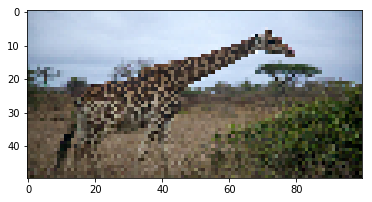

In [101]:
# take care! size should be (width, height).
aug = mx.image.ForceResizeAug(size=(100, 50))
aug_image = aug(example_image)
plot_mx_array(aug_image, clip=True)

print("example_image shape: " + str(example_image.shape))
print("aug_image shape: " + str(aug_image.shape))

### Horizontal Flip 

example_image shape: (427, 640, 3)
aug_image shape: (427, 640, 3)


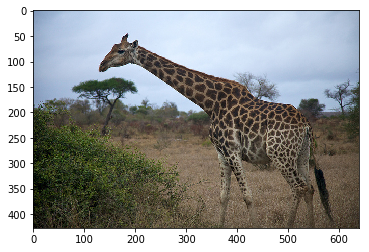

In [102]:
# p is the probability of a flip occuring, set to 1 for demonstration purposes.
aug = mx.image.HorizontalFlipAug(p=1)
aug_image = aug(example_image)
plot_mx_array(aug_image, clip=True)

print("example_image shape: " + str(example_image.shape))
print("aug_image shape: " + str(aug_image.shape))

You can get a vertical flip too using `mx.nd.swapaxes` (to switch height and width) before and after the horizontal flip.

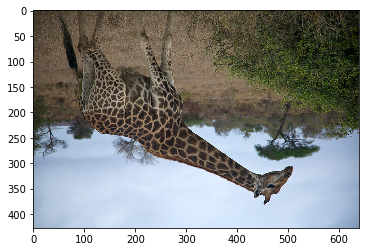

In [103]:
# p is the probability of a flip occuring, set to 1 for demonstration purposes.
aug = mx.image.HorizontalFlipAug(p=1)
aug_image = aug(example_image.swapaxes(0,1))
plot_mx_array(aug_image.swapaxes(0,1), clip=True)

# Color Augmentation

Another form of augmentation changes the pixel values, rather than the pixel positions. Since some of these functions don't have obvious implentations, code snippets have been provided for most augmenters.

__*Watch Out!*__ Unlike with positional augmentation, the color augmentation functions edit the input images inplace.
So you'll need to copy the image if you want to make augmentations on the same image independently.

### Brightness

Add a random brightness jitter to images. More precisely the image values are multiplied by a random `alpha` value, as given by;

    alpha = 1.0 + random.uniform(-brightness, brightness)
    image *= alpha

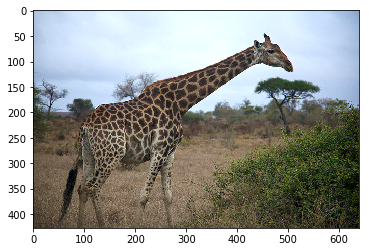

In [104]:
example_image_copy = example_image.copy()
aug = mx.image.BrightnessJitterAug(brightness=1)
aug_image = aug(example_image_copy)
plot_mx_array(aug_image, clip=True)

### Contrast

Adds a random contrast jitter to an image, as given by;

    coef = nd.array([[[0.299, 0.587, 0.114]]])
    alpha = 1.0 + random.uniform(-contrast, contrast)
    gray = src * coef
    gray = (3.0 * (1.0 - alpha) / gray.size) * nd.sum(gray)
    image *= alpha
    image += gray

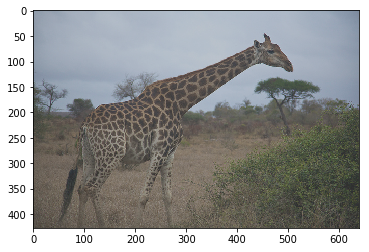

In [105]:
example_image_copy = example_image.copy()
aug = mx.image.ContrastJitterAug(contrast=1)
aug_image = aug(example_image_copy)
plot_mx_array(aug_image, clip=True)

### Saturation 

Adds a random saturation jitter to an image (i.e. changes the 'amount' of color), as per the method detailed [here](https://beesbuzz.biz/code/hsv_color_transforms.php).

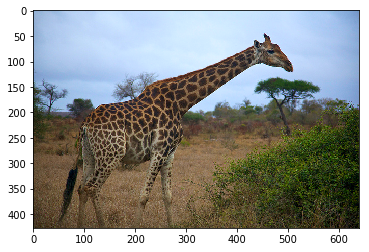

In [106]:
example_image_copy = example_image.copy()
aug = mx.image.SaturationJitterAug(saturation=1)
aug_image = aug(example_image_copy)
plot_mx_array(aug_image, clip=True)

### Hue

Adds a random hue jitter to images (i.e. changes the 'shade' of the colors), as per the method detailed [here](https://beesbuzz.biz/code/hsv_color_transforms.php).

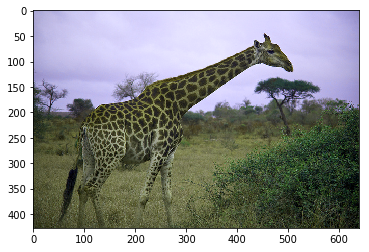

In [107]:
example_image_copy = example_image.copy()
aug = mx.image.HueJitterAug(hue=0.5)
aug_image = aug(example_image_copy)
plot_mx_array(aug_image, clip=True)

### LightingAug

Add PCA based noise, using the following method;

    alpha = np.random.normal(0, alphastd, size=(3,))
    rgb = np.dot(eigvec * alpha, eigval)
    image += nd.array(rgb)

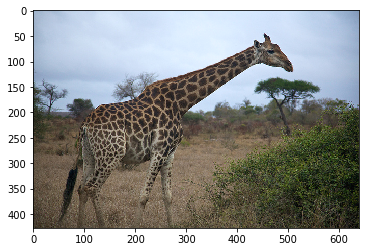

In [108]:
example_image_copy = example_image.copy()
aug = mx.image.LightingAug(alphastd=100, eigval=np.asarray([1,1,1]), eigvec=np.ones((3,3)))
aug_image = aug(example_image_copy)
plot_mx_array(aug_image, clip=True)

### Color Normalization 

Given a per channel mean and standard deviation, `ColorNormalizeAug` will normalise the values on each channel, as given by;

    if mean is not None:
        image -= mean
    if std is not None:
        image /= std

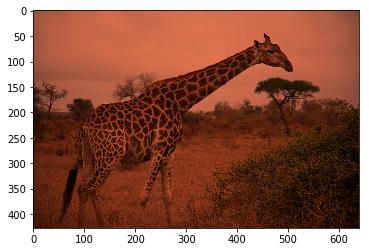

In [109]:
example_image_copy = example_image.copy()
mean = [0, 10, 20]
# if calculate the true mean, each channel in the output will be 0 centered 
stdev = [1, 2, 3]
# if calculate the true standard deviation, each channel in the output will have unit variance
aug = mx.image.ColorNormalizeAug(mean=mean, std=stdev)
aug_image = aug(example_image_copy)
plot_mx_array(aug_image, clip=True)

###  Grayscale

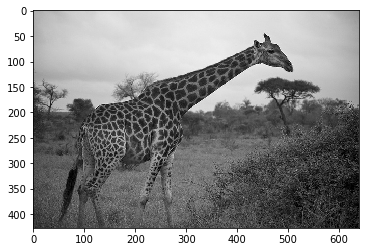

In [110]:
example_image_copy = example_image.copy()
# p is the probability of a greyscale occuring, set to 1 for demonstration purposes.
aug = mx.image.RandomGrayAug(p=1)
aug_image = aug(example_image_copy)
plot_mx_array(aug_image, clip=True)

# Combinations 

Some shortcut functions are provided to perform multiple augmentation in a single function.

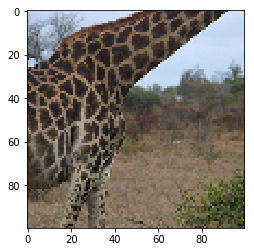

In [111]:
# A random crop, with a random resizing, and random aspect ratio jitter
example_image_copy = example_image.copy()
aug = mx.image.RandomSizedCropAug(size=(100, 100), min_area=0.1, ratio=(1.0, 1.5))
aug_image = aug(example_image_copy)
plot_mx_array(aug_image, clip=True)

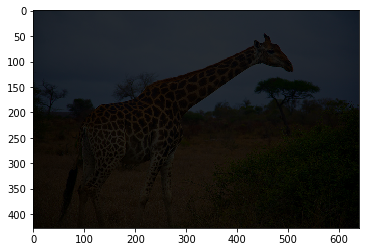

In [114]:
# A random brightness, contrast and saturation jitter in random order.
example_image_copy = example_image.copy()
aug = mx.image.ColorJitterAug(brightness=1, contrast=1, saturation=1)
aug_image = aug(example_image_copy)
plot_mx_array(aug_image, clip=True)

And lastly, you can use `RandomOrderAug` to apply multiple augmenters to an image, in a random order.

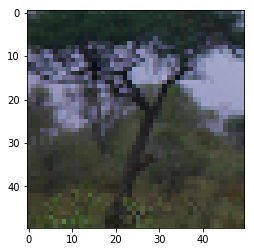

In [113]:
example_image_copy = example_image.copy()
aug_list = [
    mx.image.RandomCropAug(size=(100, 100)),
    mx.image.ResizeAug(size=50),
    mx.image.HorizontalFlipAug(p=1),
    mx.image.BrightnessJitterAug(brightness=1),
    mx.image.HueJitterAug(hue=0.5)
]
aug = mx.image.RandomOrderAug(aug_list)
aug_image = aug(example_image_copy)
plot_mx_array(aug_image, clip=True)

# Custom Augmenters

And if you're still hungry for more augmenters, you can always write your own by augmenter by inheriting the `Augmenter` base class, and defining your own `__call__` method.

# FAQs

#### 1) What shape should be used?

ImageIter returns 3 * height * width. It forces you to set data_shape; and checks the first dim is set to 3!
Also if height and width are different from the image source, it crops and/or scales. Scaling is applied equally in both height and width axes so image isn't streched.

Augmenters seem to work with arrays of a different shape though; height x width x channel.
Same as with Matplotlib ploting functions.

Switching with `mx.nd.swapaxes` is needed if working directly with the image arrays,
but if you're performing data augmentation with the ImageIter (i.e. using the `aug_list` argument),
this is taken care of automatically.


#### 2) What channel order should be used?

MXNet's default is Red, Green, Blue (RGB), while OpenCV's default is Blue, Green, Red (BGR).


#### 3) What value range should be used?

ImageIter loads image arrays as `numpy.float32` in the range 0.0 to 255.0.
Although the data type is float, no values lie between intergers.

After passing images through augmenters, often the values fall outside the range 0 to 255;
one example is adding brightness jitter to pixels already close to the range boundary.
Often this isn't an issue but clipping is performed in the plot function to be more explicit.

#### 4) Are augmentations performed on GPU?